#Dependências

In [1]:
#!pip -q install torch torchvision torchaudio
#!pip -q install torch_geometric
#!pip -q install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cpu.html

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

# Tratar dados
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix


import re
from imblearn.under_sampling import RandomUnderSampler

# Importando CSV
#from google.colab import drive

# PyG
import torch
from torch_geometric.data import Data
from torch_geometric.utils import remove_isolated_nodes
from torch_geometric.utils import contains_isolated_nodes
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch import nn

### Lendo CSV do Google Drive

In [3]:
filename = "./data/covid_es_dados.es.gov.br.csv"
#drive.mount('/content/drive')
#filename = '/content/drive/MyDrive/BSI/2023-2/PD2/Datasets/covid_es_dados.es.gov.br.csv'
covid_df = pd.read_csv(filename, sep=";", index_col=False, encoding="iso-8859-1")
#covid_df = pd.read_csv(filename, sep=";", index_col=False, encoding="iso-8859-1")

C:\Users\ezequ\AppData\Local\Temp\ipykernel_12016\3692900595.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_df = pd.read_csv(filename, sep=";", index_col=False, encoding="iso-8859-1")


In [4]:
covid_df.shape

(4897896, 45)

In [5]:
covid_df.head()

,DataNotificacao,DataCadastro,DataDiagnostico,DataColeta_RT_PCR,DataColetaTesteRapido,DataColetaSorologia,DataColetaSorologiaIGG,DataEncerramento,DataObito,Classificacao,...,ViagemBrasil,ViagemInternacional,ProfissionalSaude,PossuiDeficiencia,MoradorDeRua,ResultadoRT_PCR,ResultadoTesteRapido,ResultadoSorologia,ResultadoSorologia_IGG,TipoTesteRapido
0,2023-09-19,2023-09-19,2023-09-14,NaN,NaN,NaN,NaN,NaN,NaN,Suspeito,...,Não,Não,Não,Não,Não,Não Informado,Não Informado,Não Informado,Não Informado,Não Informado
1,2023-09-19,2023-09-19,2023-09-18,NaN,2023-09-19,NaN,NaN,NaN,NaN,Síndrome Gripal não Especificada,...,Não,Não,Não,Não,Não,Não Informado,Negativo,Não Informado,Não Informado,Teste rápido Antígeno
2,2023-09-19,2023-09-19,2023-09-17,NaN,2023-09-19,NaN,NaN,NaN,NaN,Suspeito,...,Não,Não,Não,Não,Não,Não Informado,Negativo,Não Informado,Não Informado,Teste rápido Antígeno
3,2023-09-19,2023-09-19,2023-09-16,NaN,NaN,NaN,NaN,NaN,NaN,Suspeito,...,Não,Não,Não,Não,Não,Não Informado,Não Informado,Não Informado,Não Informado,Não Informado
4,2023-09-19,2023-09-19,2023-09-17,NaN,2023-09-19,NaN,NaN,NaN,NaN,Suspeito,...,Não,Não,Não,Não,Não,Não Informado,Negativo,Não Informado,Não Informado,Teste rápido Antígeno


In [6]:
covid_df.describe()

,DataNotificacao,DataCadastro,DataDiagnostico,DataColeta_RT_PCR,DataColetaTesteRapido,DataColetaSorologia,DataColetaSorologiaIGG,DataEncerramento,DataObito,Classificacao,...,ViagemBrasil,ViagemInternacional,ProfissionalSaude,PossuiDeficiencia,MoradorDeRua,ResultadoRT_PCR,ResultadoTesteRapido,ResultadoSorologia,ResultadoSorologia_IGG,TipoTesteRapido
count,4897896,4897896,4897896,1520711,3070871,99794,146531,4673619,21876,4897896,...,4897896,4897896,4897896,4897896,4897896,4897896,4897896,4897896,4897896,4897896
unique,1302,1272,1390,1433,1515,976,977,1377,1231,4,...,4,4,4,3,3,4,4,4,4,4
top,2022-01-27,2022-01-27,2022-01-24,2021-03-22,2022-01-27,2020-07-20,2020-07-28,2022-03-31,2021-04-12,Descartados,...,Não,Não,Não,Não,Não,Não Informado,Negativo,Não Informado,Não Informado,Teste rápido Antígeno
freq,42158,37772,40789,5269,39544,960,2715,164075,97,3053220,...,3145459,3098218,4313582,4827398,4848134,3468646,2213330,4798625,4751578,2738095


In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4897896 entries, 0 to 4897895
Data columns (total 45 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   DataNotificacao          object
 1   DataCadastro             object
 2   DataDiagnostico          object
 3   DataColeta_RT_PCR        object
 4   DataColetaTesteRapido    object
 5   DataColetaSorologia      object
 6   DataColetaSorologiaIGG   object
 7   DataEncerramento         object
 8   DataObito                object
 9   Classificacao            object
 10  Evolucao                 object
 11  CriterioConfirmacao      object
 12  StatusNotificacao        object
 13  Municipio                object
 14  Bairro                   object
 15  FaixaEtaria              object
 16  IdadeNaDataNotificacao   object
 17  Sexo                     object
 18  RacaCor                  object
 19  Escolaridade             object
 20  Gestante                 object
 21  Febre                    object

# Pré Tratamento

### Casos confirmados

#### Obtendo Classificao diretamente

In [8]:
# Apenas casos confirmados
covid_df = covid_df[covid_df.Classificacao == "Confirmados"]
covid_df.shape

(1340445, 45)

### Tratando DataObito

In [9]:
# A Data vazia significa que o paciente sobreviveu
covid_df['DataObito'].isna().sum()

1324855

In [10]:
covid_df['DataObito'].value_counts(dropna=False)

DataObito
NaN           1324855
2021-04-12         92
2021-04-19         90
2021-04-09         85
2021-04-08         82
               ...   
2022-10-11          1
2022-10-28          1
2022-11-18          1
2022-10-18          1
2020-04-04          1
Name: count, Length: 1021, dtype: int64

In [11]:
# Substituir os valores NaN na coluna 'A' pela média da coluna
covid_df.DataObito.fillna(0, inplace=True)

# Cria nova coluna binaria e preenche com os valores baseando na coluna DataObito
covid_df['PASSED'] = [1 if (l != 0) else l for l in covid_df.DataObito]

covid_df.PASSED.value_counts()

PASSED
0    1324855
1      15590
Name: count, dtype: int64

### Coluna 'IdadeNaDataNotificacao'

In [12]:
# Transforma idade "13 anos, 11 meses e 15 dias" em "13" (int)
idade_regex = r"(\d+)"
covid_df["IdadeNaDataNotificacao"] = covid_df["IdadeNaDataNotificacao"].str.extract(idade_regex).astype(int)

# Explorando Dados

### Descrevendo dataframe

In [13]:
for i in covid_df.columns:
    print(i,"----->", len(covid_df[i].unique()))

DataNotificacao -----> 1288
DataCadastro -----> 1270
DataDiagnostico -----> 1329
DataColeta_RT_PCR -----> 1338
DataColetaTesteRapido -----> 1363
DataColetaSorologia -----> 838
DataColetaSorologiaIGG -----> 842
DataEncerramento -----> 1304
DataObito -----> 1021
Classificacao -----> 1
Evolucao -----> 5
CriterioConfirmacao -----> 4
StatusNotificacao -----> 2
Municipio -----> 1089
Bairro -----> 3634
FaixaEtaria -----> 12
IdadeNaDataNotificacao -----> 115
Sexo -----> 3
RacaCor -----> 6
Escolaridade -----> 11
Gestante -----> 7
Febre -----> 3
DificuldadeRespiratoria -----> 3
Tosse -----> 3
Coriza -----> 3
DorGarganta -----> 3
Diarreia -----> 3
Cefaleia -----> 3
ComorbidadePulmao -----> 3
ComorbidadeCardio -----> 3
ComorbidadeRenal -----> 3
ComorbidadeDiabetes -----> 3
ComorbidadeTabagismo -----> 3
ComorbidadeObesidade -----> 3
FicouInternado -----> 4
ViagemBrasil -----> 4
ViagemInternacional -----> 4
ProfissionalSaude -----> 4
PossuiDeficiencia -----> 3
MoradorDeRua -----> 3
ResultadoRT_PCR -

### Percentual de mortes

In [14]:
def plot_percentual_deads(df):
    percentual_deads = round(df.PASSED.mean() * 100, 2)
    print(f"Percentural of deads {percentual_deads}]\n")

    ax = df.PASSED.value_counts(dropna=False).plot(kind="bar", title=f"Pacientes x Morte -> ({percentual_deads}%)", color=["blue", "red"], ylabel="Qtd. Pacientes")

    container = ax.containers[0]
    ax.bar_label(container)
    ax.set_xticklabels(["Sobrevieu", "Morreu"], rotation=0)


Percentural of deads 1.16]



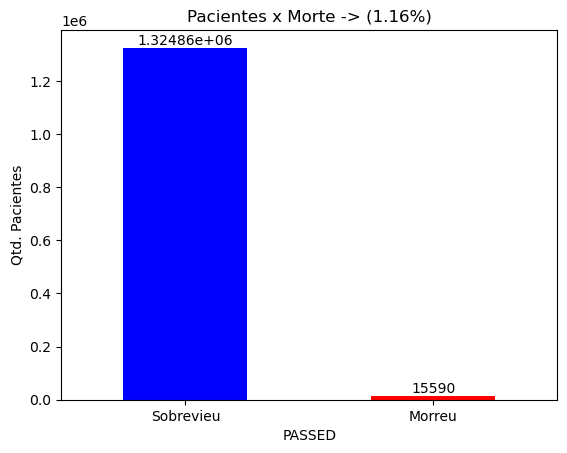

In [15]:
plot_percentual_deads(covid_df)

### Casos confirmados

#### Obtendo Classificao diretamente

In [16]:
# Apenas casos confirmados
covid_df = covid_df[covid_df.Classificacao == "Confirmados"]
covid_df.PASSED.value_counts(dropna=False)

PASSED
0    1324855
1      15590
Name: count, dtype: int64

In [17]:
covid_df.shape

(1340445, 46)

# Tratando Dados

### Coluna 'Classificacao'

In [18]:
# O dataset foi filtrado por apenas casos 'Confirmados'
# Por isso, torna-se uma coluna constante, assim será removida

print(covid_df.Classificacao.value_counts(dropna=True))
covid_df.drop(columns=["Classificacao"], inplace=True)

Classificacao
Confirmados    1340445
Name: count, dtype: int64


### Tratando colunas com valor 'Ignorado', 'Não Informado' ou '-'
*   As colunas abaixo demostram exemplos dos valores 'Ignorado' e 'Não Informado'
que são recorrentes na base de dados


In [19]:
covid_df.FicouInternado.value_counts(dropna=False)

FicouInternado
Não              806252
Não Informado    495930
Ignorado          24337
Sim               13926
Name: count, dtype: int64

In [20]:
covid_df.DorGarganta.value_counts()

DorGarganta
Não    877843
Sim    461296
-        1306
Name: count, dtype: int64

In [21]:
covid_df.ViagemBrasil.value_counts()

ViagemBrasil
Não              826058
Não Informado    434027
Ignorado          41030
Sim               39330
Name: count, dtype: int64

In [22]:
# Converte os valores para NaN
covid_df.replace("Ignorado", np.nan, inplace=True)
covid_df.replace("Não Informado", np.nan, inplace=True)
covid_df.replace("-", np.nan, inplace=True)

### Tratando coluna 'Sexo'

In [23]:
# Valores para coluna Sexo
covid_df.Sexo.value_counts(dropna=False)

Sexo
F    755318
M    584911
I       216
Name: count, dtype: int64

In [24]:
# Redefine valor para colunas com valores I (provavelmente refere-se a indefinido)
covid_df.Sexo.replace("I", np.nan, inplace=True)

### Coluna 'Gestante'

In [25]:
# Valores usados para a coluna de Gestante
covid_df.Gestante.value_counts()

Gestante
Não                           725468
Não se aplica                 586833
3º trimeste                     2494
2º trimeste                     2171
1º trimeste                     1493
Idade gestacional ignorada       946
Name: count, dtype: int64

In [26]:
# Transformando em valores em 'Não'
# Se é mulher e 'Não se aplica', então não está grávida e homem não pode estar de gestação
covid_df.Gestante.replace("Não se aplica", "Não", inplace=True)
covid_df.Gestante.replace("Idade gestacional ignorada", "Não", inplace=True)

In [27]:
covid_df.Gestante.value_counts()

Gestante
Não            1313247
3º trimeste       2494
2º trimeste       2171
1º trimeste       1493
Name: count, dtype: int64

In [28]:
# Há ruídos que demostram gestação para pacientes do sexo masculino
covid_df[covid_df.Sexo == 'M'].Gestante.value_counts()

Gestante
Não            581103
2º trimeste         5
3º trimeste         4
1º trimeste         1
Name: count, dtype: int64

In [29]:
# Tranforma tais ruídos em 'Não'
covid_df.loc[covid_df.Sexo == 'M', "Gestante"] = "Não"
covid_df[covid_df.Sexo == 'M'].Gestante.value_counts()

Gestante
Não    584911
Name: count, dtype: int64

In [30]:
# A relação de valores 'Não', sem considerar NaN, para o total de elementos é de 97.8%
# Dessa forma, essa coluna se torna uma constante que pode ser ignorada
covid_df.Gestante.value_counts(dropna=False)

Gestante
Não            1317055
NaN              17242
3º trimeste       2490
2º trimeste       2166
1º trimeste       1492
Name: count, dtype: int64

### Coluna 'Evolucao'

In [31]:
# Essa coluna possui informação similar a varável alvo, por isso
# precisa ser removida
covid_df.Evolucao.value_counts(dropna=True)

Evolucao
Cura                       1301677
Óbito pelo COVID-19          15112
Óbito por outras causas        448
Name: count, dtype: int64

### Colunas NaN

In [32]:
def verify_num_cols(df):
    # Média ordenada e colunas com valor vazio
    mean_na = df.isna().mean().sort_values(ascending=False)

    # Cria DF de colunas nulas
    df_na = pd.DataFrame({"percentual": mean_na})

    return df_na

def remove_nan_cols_above_limit(df, cols_to_ignore, limit=0.30):
    # Obtém colunas nulas e seu percentual
    df_na = verify_num_cols(df)

    # Ignora colunas
    df_na.drop(cols_to_ignore, inplace=True)

    # Filtra colunas pelo limite
    df_na_above_limit = df_na[df_na.percentual >= limit]

    # Obtém as colunas a serem dropadas
    columns_to_drop = df_na_above_limit.index

    # Dropa colunas
    df.drop(columns=columns_to_drop, inplace=True)

    return df, df_na_above_limit

In [33]:
# Remove colunas nulas acima do limite de 5%
# Coluna considera importante para ser removida
cols_to_ignore = ["FicouInternado"]
_, df_na = remove_nan_cols_above_limit(covid_df, cols_to_ignore, limit=0.05)

# Colunas removidas
df_na

,percentual
ResultadoSorologia,0.963691
DataColetaSorologia,0.963563
ResultadoSorologia_IGG,0.956279
DataColetaSorologiaIGG,0.956232
ResultadoRT_PCR,0.665297
DataColeta_RT_PCR,0.660597
Escolaridade,0.399611
ViagemInternacional,0.394779
TipoTesteRapido,0.393348
ViagemBrasil,0.354402


In [34]:
covid_df.shape

(1340445, 31)

In [35]:
covid_df.isna().sum()

DataNotificacao                 0
DataCadastro                    0
DataDiagnostico                 0
DataEncerramento            16515
DataObito                       0
Evolucao                    23208
CriterioConfirmacao          5393
StatusNotificacao               0
Municipio                       0
Bairro                       9100
FaixaEtaria                    32
IdadeNaDataNotificacao          0
Sexo                          216
Gestante                    17242
Febre                        1329
DificuldadeRespiratoria      1239
Tosse                        1264
Coriza                       1268
DorGarganta                  1306
Diarreia                     1278
Cefaleia                     1304
ComorbidadePulmao            1611
ComorbidadeCardio            1574
ComorbidadeRenal             1505
ComorbidadeDiabetes          1552
ComorbidadeTabagismo         1550
ComorbidadeObesidade         1741
FicouInternado             520267
PossuiDeficiencia            7304
MoradorDeRua  

### Transformando Datas

* O padrão visto nas datas é de yyyy-mm-dd, porém algumas colunas possuem valores que escapam desse padrão, assim, gerando ruídos,como por exemplo: 0202-03-21.
* Além disso, tais colunas não são necessárias.

In [36]:
covid_df.drop(columns=['DataDiagnostico', 'DataEncerramento', "DataObito","DataCadastro", "DataNotificacao"], inplace=True)

In [37]:
covid_df.columns

Index(['Evolucao', 'CriterioConfirmacao', 'StatusNotificacao', 'Municipio',
       'Bairro', 'FaixaEtaria', 'IdadeNaDataNotificacao', 'Sexo', 'Gestante',
       'Febre', 'DificuldadeRespiratoria', 'Tosse', 'Coriza', 'DorGarganta',
       'Diarreia', 'Cefaleia', 'ComorbidadePulmao', 'ComorbidadeCardio',
       'ComorbidadeRenal', 'ComorbidadeDiabetes', 'ComorbidadeTabagismo',
       'ComorbidadeObesidade', 'FicouInternado', 'PossuiDeficiencia',
       'MoradorDeRua', 'PASSED'],
      dtype='object')

### Removendo colunas desnecessárias

* Bairro/Municipio - Valores descritivos
* StatusNotificacao - Se torna constante após tratamentos
* Evolução - Possui informação similar a variável alvo
* Gestante - Coluna consante

In [38]:
# Remover DataNotificacao DataColetaTesteRapido
covid_df.drop(columns=["Bairro", "Municipio", "StatusNotificacao", "Evolucao", "Gestante"], inplace=True)

In [39]:
# Remove linhas com alguma coluna nula
covid_df.dropna(inplace=True)

In [40]:
for i in covid_df.columns:
    print(i,"----->", len(covid_df[i].unique()))

CriterioConfirmacao -----> 3
FaixaEtaria -----> 11
IdadeNaDataNotificacao -----> 113
Sexo -----> 2
Febre -----> 2
DificuldadeRespiratoria -----> 2
Tosse -----> 2
Coriza -----> 2
DorGarganta -----> 2
Diarreia -----> 2
Cefaleia -----> 2
ComorbidadePulmao -----> 2
ComorbidadeCardio -----> 2
ComorbidadeRenal -----> 2
ComorbidadeDiabetes -----> 2
ComorbidadeTabagismo -----> 2
ComorbidadeObesidade -----> 2
FicouInternado -----> 2
PossuiDeficiencia -----> 2
MoradorDeRua -----> 2
PASSED -----> 2


### Remove caracteres especiais e espaços em branco
* Quando utilizado o OneHot-Encoder, é necessário remover tais carácteres,
senão, as colunas fugirão do padrão.

In [41]:
def remove_specials_chars(char, chars_to_replace):
    if(isinstance(char, str)):
        # Remove espaçamento
        char = char.strip()
        
        # Substitui espaçamento entre palavras
        char = char.replace(" ", "_")
        
        # Remove caracter
        for c_key in chars_to_replace.keys():
            char = char.replace(c_key, chars_to_replace[c_key])
            
    return char

In [42]:
# Carácteres a serem substituídos
chars_to_replace = {'ã': 'a', 'ó': 'o', 'Ó': 'O'}

# Aplica substituição
covid_df = covid_df.applymap(lambda x: remove_specials_chars(x, chars_to_replace))

In [43]:
covid_df.PASSED.value_counts(dropna=False)

PASSED
0    801067
1     11366
Name: count, dtype: int64

# Encoding

## Label Encoding

In [44]:
label_encoder = LabelEncoder()

In [45]:
covid_df["FaixaEtaria"] = label_encoder.fit_transform(covid_df["FaixaEtaria"])

## One-hot Encoding

In [46]:
# Define colunas a serem ignoradas
ignore_columns = ["FaixaEtaria", "IdadeNaDataNotificacao", "PASSED", "DataNotificacao"]
onehot_encoder_cols = [col for col in covid_df.columns.tolist() if col not in ignore_columns]

# Instancia o OneHotEnconder
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [47]:
# Realiza o fit-transform
one_hot_result = one_hot_encoder.fit_transform(covid_df[onehot_encoder_cols])

# Obtem os nomes das colunas
one_hot_col_result = one_hot_encoder.get_feature_names_out(onehot_encoder_cols)

# Armazena em um novo DF
one_hot_col_df = pd.DataFrame(one_hot_result, columns=one_hot_col_result, index=covid_df.index)
one_hot_col_df.shape

(812433, 37)

In [48]:
one_hot_col_result

array(['CriterioConfirmacao_Clinico',
       'CriterioConfirmacao_Clinico_Epdemiologico',
       'CriterioConfirmacao_Laboratorial', 'Sexo_F', 'Sexo_M',
       'Febre_Nao', 'Febre_Sim', 'DificuldadeRespiratoria_Nao',
       'DificuldadeRespiratoria_Sim', 'Tosse_Nao', 'Tosse_Sim',
       'Coriza_Nao', 'Coriza_Sim', 'DorGarganta_Nao', 'DorGarganta_Sim',
       'Diarreia_Nao', 'Diarreia_Sim', 'Cefaleia_Nao', 'Cefaleia_Sim',
       'ComorbidadePulmao_Nao', 'ComorbidadePulmao_Sim',
       'ComorbidadeCardio_Nao', 'ComorbidadeCardio_Sim',
       'ComorbidadeRenal_Nao', 'ComorbidadeRenal_Sim',
       'ComorbidadeDiabetes_Nao', 'ComorbidadeDiabetes_Sim',
       'ComorbidadeTabagismo_Nao', 'ComorbidadeTabagismo_Sim',
       'ComorbidadeObesidade_Nao', 'ComorbidadeObesidade_Sim',
       'FicouInternado_Nao', 'FicouInternado_Sim',
       'PossuiDeficiencia_Nao', 'PossuiDeficiencia_Sim',
       'MoradorDeRua_Nao', 'MoradorDeRua_Sim'], dtype=object)

In [49]:
# Dropa colunas antigas e adiciona as novas
covid_df = covid_df.drop(columns=onehot_encoder_cols).join(one_hot_col_df)
covid_df.shape

(812433, 40)

In [50]:
# Liberar Memoria
del one_hot_col_df
del one_hot_result

In [51]:
covid_df.head()

,FaixaEtaria,IdadeNaDataNotificacao,PASSED,CriterioConfirmacao_Clinico,CriterioConfirmacao_Clinico_Epdemiologico,CriterioConfirmacao_Laboratorial,Sexo_F,Sexo_M,Febre_Nao,Febre_Sim,...,ComorbidadeTabagismo_Nao,ComorbidadeTabagismo_Sim,ComorbidadeObesidade_Nao,ComorbidadeObesidade_Sim,FicouInternado_Nao,FicouInternado_Sim,PossuiDeficiencia_Nao,PossuiDeficiencia_Sim,MoradorDeRua_Nao,MoradorDeRua_Sim
8,3,26,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
11,3,26,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
15,4,35,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
36,3,27,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
40,3,26,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Balanceando Dados

In [52]:
rus = RandomUnderSampler(sampling_strategy='majority')
X,y = rus.fit_resample(covid_df.drop(columns=["PASSED"]), covid_df.PASSED)

In [53]:
y.value_counts()

PASSED
0    11366
1    11366
Name: count, dtype: int64

# Transformando Dataset em estrutura para grafo

## Determinado propriedades
* Nodes -> Pessoas (cada linha da tabela)
* Edges -> Similaridade das doenças de cada pessoa
* Nodes features -> Comorbidades, etc.
* Labels -> Se a pessoa pode morrer por covid

## Extraindo Node Features

In [54]:
X.columns

Index(['FaixaEtaria', 'IdadeNaDataNotificacao', 'CriterioConfirmacao_Clinico',
       'CriterioConfirmacao_Clinico_Epdemiologico',
       'CriterioConfirmacao_Laboratorial', 'Sexo_F', 'Sexo_M', 'Febre_Nao',
       'Febre_Sim', 'DificuldadeRespiratoria_Nao',
       'DificuldadeRespiratoria_Sim', 'Tosse_Nao', 'Tosse_Sim', 'Coriza_Nao',
       'Coriza_Sim', 'DorGarganta_Nao', 'DorGarganta_Sim', 'Diarreia_Nao',
       'Diarreia_Sim', 'Cefaleia_Nao', 'Cefaleia_Sim', 'ComorbidadePulmao_Nao',
       'ComorbidadePulmao_Sim', 'ComorbidadeCardio_Nao',
       'ComorbidadeCardio_Sim', 'ComorbidadeRenal_Nao', 'ComorbidadeRenal_Sim',
       'ComorbidadeDiabetes_Nao', 'ComorbidadeDiabetes_Sim',
       'ComorbidadeTabagismo_Nao', 'ComorbidadeTabagismo_Sim',
       'ComorbidadeObesidade_Nao', 'ComorbidadeObesidade_Sim',
       'FicouInternado_Nao', 'FicouInternado_Sim', 'PossuiDeficiencia_Nao',
       'PossuiDeficiencia_Sim', 'MoradorDeRua_Nao', 'MoradorDeRua_Sim'],
      dtype='object')

In [55]:
# Reseta o index
covid_df = covid_df.reset_index(drop=True)
X = X.reset_index(drop=True)

In [56]:
personal_info = ['IdadeNaDataNotificacao', 'FaixaEtaria',
                 'Sexo_F', 'Sexo_M',
                 'PossuiDeficiencia_Nao', 'PossuiDeficiencia_Sim']

clinicians = ['CriterioConfirmacao_Clinico',
       'CriterioConfirmacao_Clinico_Epdemiologico',
       'CriterioConfirmacao_Laboratorial',
       'FicouInternado_Sim', 'FicouInternado_Nao']

comorbities = ['ComorbidadePulmao_Nao', 'ComorbidadePulmao_Sim',
       'ComorbidadeCardio_Nao', 'ComorbidadeCardio_Sim',
       'ComorbidadeRenal_Nao', 'ComorbidadeRenal_Sim',
       'ComorbidadeDiabetes_Nao', 'ComorbidadeDiabetes_Sim',
       'ComorbidadeTabagismo_Nao', 'ComorbidadeTabagismo_Sim',
       'ComorbidadeObesidade_Nao', 'ComorbidadeObesidade_Sim']

symptoms = ['Febre_Nao', 'Febre_Sim',
       'DificuldadeRespiratoria_Nao', 'DificuldadeRespiratoria_Sim',
       'Tosse_Nao', 'Tosse_Sim', 'Coriza_Nao', 'Coriza_Sim', 'DorGarganta_Nao',
       'DorGarganta_Sim', 'Diarreia_Nao', 'Diarreia_Sim', 'Cefaleia_Nao',
       'Cefaleia_Sim']

In [57]:
features = personal_info + comorbities + clinicians + symptoms

all_features = X[features].to_numpy()
X.drop(columns=features, inplace=True)
all_features

array([[24.,  3.,  1., ...,  0.,  0.,  1.],
       [43.,  5.,  1., ...,  0.,  0.,  1.],
       [35.,  4.,  1., ...,  0.,  1.,  0.],
       ...,
       [59.,  6.,  0., ...,  0.,  1.,  0.],
       [58.,  6.,  1., ...,  0.,  1.,  0.],
       [50.,  6.,  0., ...,  1.,  0.,  1.]])

## Definindo similaridade

In [59]:
# Calcula a similaridade do cosseno para os pacientes
similarity = cosine_similarity(all_features)

In [60]:
# Defini um limiar para existir uma relação entre os pacientes
threshold = 0.9991

# Cria a lista de adjacencia
adjacency_list = [[],[]]

# O resultado de similarity, é uma matriz de paciente x pacientes
# Onde cada elemento é o cosseno da similaridade
# Assim, percorremos paciente x parciente
for pac_i in range(len(similarity)):
    for pac_j in range(pac_i + 1, len(similarity[pac_i])):
        value = similarity[pac_i][pac_j]

        # True, Se o paciente não for si mesmo (i!=j) e
        #o cosseno da similiaridade for maior que o limiar

        if(pac_i != pac_j and value >= threshold):
            # Adiciona a->b e b->a
            adjacency_list[0].append(pac_i)
            adjacency_list[1].append(pac_j)

            adjacency_list[0].append(pac_j)
            adjacency_list[1].append(pac_i)

In [61]:
len(adjacency_list[0])

60249700

## Usando Pyg

In [62]:
X_features = torch.from_numpy(all_features).float()
y_target = torch.from_numpy(y.to_numpy())

In [63]:
torch.from_numpy(all_features.astype(np.double))

tensor([[24.,  3.,  1.,  ...,  0.,  0.,  1.],
        [43.,  5.,  1.,  ...,  0.,  0.,  1.],
        [35.,  4.,  1.,  ...,  0.,  1.,  0.],
        ...,
        [59.,  6.,  0.,  ...,  0.,  1.,  0.],
        [58.,  6.,  1.,  ...,  0.,  1.,  0.],
        [50.,  6.,  0.,  ...,  1.,  0.,  1.]], dtype=torch.float64)

In [64]:
edge_index = torch.tensor(adjacency_list, dtype=torch.long)
edge_index,_,_ = remove_isolated_nodes(edge_index)

data = Data(x=X_features, edge_index=edge_index, y=y_target)

In [65]:
# Liberar memória
del adjacency_list

In [66]:
def show_data_info(data):
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

show_data_info(data)

Number of nodes: 22732
Number of edges: 60249700
Average node degree: 2650.44
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [67]:
# Obtendo maior componente
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.transforms as T

In [68]:
transform = LargestConnectedComponents()
data = transform(data)

In [69]:
show_data_info(data)

Number of nodes: 21335
Number of edges: 60248044
Average node degree: 2823.91
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Split dados

In [70]:
def split_in_masks(data, val=0.1, test=0.3):
    # resetting data split
    split = T.RandomNodeSplit(num_val=val, num_test=test)

    # print(
    #     f"train: {int(data.train_mask.sum())}, ",
    #     f"val: {int(data.val_mask.sum())}, ",
    #     f"test: {int(data.test_mask.sum())}",
    # )

    return split(data)


## GCN

## Funções Auxiliares

In [71]:
def computes_metrics(target_labels, pred_labels):
    accuracy = accuracy_score(target_labels, pred_labels)
    f1 = f1_score(target_labels, pred_labels)
    roc_auc = roc_auc_score(target_labels, pred_labels)
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    
    return accuracy, precision, recall, f1, roc_auc

def get_df_results(size, csv_name):
    # Busca Df já escrito, caso não enconte, instancia um novo
    df_results = None
    try:
        df_results = pd.read_csv(csv_name, sep=",", index_col=0)
    except FileNotFoundError:
        df_results = pd.DataFrame(data=np.zeros(size))
    
    return df_results

def save_metrics(size, resultado, run):
    # Mudar o nome para cada grupo de rn_runs
    csv_name = "./results/gcn_es_runs"

    # Obtem Df results    
    df_results = get_df_results(size, csv_name)

    # Escreve as métricas na coluna run respectiva
    df_results.iloc[:, run] = list(resultado)
    
    # Escreve df modificado
    df_results.to_csv(csv_name)
        
def print_metrics(pred_labels, target_labels, loss, metrics_results, epoch):
    print(f"Pred: {pred_labels.sum()}, Actual: {target_labels.sum()}")
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}')
    print(metrics_results)
    print("-----------------------------------------------")

## Execução

In [72]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 20)
        self.conv2 = GCNConv(20, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)

        return x

In [73]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward()

    optimizer.step()

    return loss

def predict(model, data, mask):
    out = model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=1)
    
    pred_labels = pred[mask]
    target_labels = data.y[mask]

    return pred_labels, target_labels

def train_epochs(model, data, optimizer, criterion, run, n_epochs=200, n_runs=10):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    splited_data = split_in_masks(data)

    for epoch in range(1, n_epochs + 1):
        loss = train(model, splited_data, optimizer, criterion)

        if epoch % 10 == 0:
            pred_labels, target_labels = predict(model, splited_data, splited_data.test_mask)

            metrics_results = computes_metrics(target_labels, pred_labels)
            print_metrics(pred_labels, target_labels, loss, metrics_results, epoch)
                
    # Salva as métricas ao fim do treinamento de cada run
    pred_labels, target_labels = predict(model, splited_data, splited_data.test_mask)
    save_metrics((len(metrics), n_runs), metrics_results, run)

In [74]:
# Definindo dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def monte_carlo_train(device, data, n_runs=10):
    # Extraindo quantidade de características e classes
    num_node_features = data.x.size(1)
    num_classes =  len(np.unique(data.y))
    
    for run in range(n_runs):
        # Instancia o modelo GCN
        gcn = GCN(num_node_features, num_classes).to(device)

        # Roda o otimizador Adam
        optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

        # Função custo
        criterion = nn.CrossEntropyLoss()

        # Treina classificador
        train_epochs(gcn, data, optimizer_gcn, criterion, run, n_epochs=200, n_runs=10)
   

monte_carlo_train(device, data)



Pred: 6400, Actual: 3135
Epoch: 010, Train Loss: 2.889
(0.48984375, 0.48984375, 1.0, 0.6575773466177243, 0.5)
-----------------------------------------------
Pred: 6400, Actual: 3135
Epoch: 020, Train Loss: 0.827
(0.48984375, 0.48984375, 1.0, 0.6575773466177243, 0.5)
-----------------------------------------------


i:\Anaconda\envs\covid_es_gnn\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred: 0, Actual: 3135
Epoch: 030, Train Loss: 0.852
(0.51015625, 0.0, 0.0, 0.0, 0.5)
-----------------------------------------------
Pred: 2766, Actual: 3135
Epoch: 040, Train Loss: 0.586
(0.84859375, 0.8915401301518439, 0.7866028708133971, 0.8357905439755974, 0.8473596283622882)
-----------------------------------------------
Pred: 3266, Actual: 3135
Epoch: 050, Train Loss: 0.522
(0.85296875, 0.8358848744641764, 0.8708133971291866, 0.8529917200437431, 0.8533240033119133)
-----------------------------------------------
Pred: 3447, Actual: 3135
Epoch: 060, Train Loss: 0.471
(0.8490625, 0.814621409921671, 0.8956937799043062, 0.853236098450319, 0.8499908409475587)
-----------------------------------------------
Pred: 3454, Actual: 3135
Epoch: 070, Train Loss: 0.429
(0.84796875, 0.8129704690214244, 0.8956937799043062, 0.852329640309607, 0.848918865449856)
-----------------------------------------------
Pred: 3461, Actual: 3135
Epoch: 080, Train Loss: 0.392
(0.8490625, 0.8133487431378215, 0

i:\Anaconda\envs\covid_es_gnn\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred: 0, Actual: 3173
Epoch: 010, Train Loss: 0.713
(0.50421875, 0.0, 0.0, 0.0, 0.5)
-----------------------------------------------
Pred: 429, Actual: 3173
Epoch: 020, Train Loss: 0.605
(0.5684375, 0.9790209790209791, 0.13236684525685471, 0.23320377568017772, 0.5647889385875224)
-----------------------------------------------
Pred: 3366, Actual: 3173
Epoch: 030, Train Loss: 0.496
(0.84703125, 0.8259061200237671, 0.8761424519382288, 0.8502829178773512, 0.8472748206390865)
-----------------------------------------------
Pred: 3727, Actual: 3173
Epoch: 040, Train Loss: 0.431
(0.8378125, 0.7864233968339147, 0.9237314843996218, 0.8495652173913043, 0.8385313759153361)
-----------------------------------------------
Pred: 3613, Actual: 3173
Epoch: 050, Train Loss: 0.401
(0.8465625, 0.8032106282867423, 0.9145918688937914, 0.8552903035661656, 0.8471316952154113)
-----------------------------------------------
Pred: 3382, Actual: 3173
Epoch: 060, Train Loss: 0.375
(0.85546875, 0.832347723240686